<!--HEADER-->
*Documentation for the EpiSiming epidemic simulation package*

<!--BADGES-->
<a href="https://colab.research.google.com/github/episiming/epsiming/blob/master/notebooks/01.04-Atributos_de_idade_e_infectividade.ipynb" target="_blank"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Google Colab" title="Open in Google Colab"></a><a href="https://mybinder.org/v2/gh/episiming/episiming/master?filepath=notebooks/01.04-Atributos_de_idade_e_infectividade.ipynb" target="_blank"><img align="left" src="https://mybinder.org/badge.svg" alt="Open in Binder" title="Open in Binder"></a><a href="https://nbviewer.jupyter.org/github/episiming/episiming/blob/master/notebooks/01.04-Atributos_de_idade_e_infectividade.ipynb" target="_blank"><img align="left" src="https://img.shields.io/badge/view%20in-nbviewer-orange" alt="View in NBViewer" title="View in NBViewer"></a><a href="https://raw.githubusercontent.com/episiming/episiming/master/notebooks/01.04-Atributos_de_idade_e_infectividade.ipynb" target="_blank"><img align="left" src="https://img.shields.io/badge/download-notebook-9cf" alt="Download Notebook" title="Download Notebook"></a>&nbsp;

<!--NAVIGATOR-->
[<- Construção dos atributos de localização](01.03-Atributos_de_localizacao.ipynb) | [Página Inicial](00.00-Pagina_Inicial.ipynb) | [Construção dos atributos de idade e infectividade potencial relativa dos indivíduos ->](01.05-Atributos_de_susceptibilidade_e_infectividade.ipynb)

---


# Construção do atributo de idade

- Vamos ver, agora, como construir o atributo **idade**.

- A construção deve levar em conta 

    - a **pirâmide etária** da região.

    - restrições quanto à **distribuição etária em função do tamanho da reisidência**.

In [1]:
import datetime

import os, sys

import yaml

import math

import random

import numpy as np
from scipy import stats
from scipy.interpolate import interp2d

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import io, base64
from IPython.display import Image, HTML

In [2]:
%cd ..
import episiming

/home/gil/repos/episiming


In [3]:
sns.set_style("darkgrid")

In [4]:
dt_string = datetime.datetime.now().strftime("%d/%b/%Y")
print(f"Atualização mais recente do kernel: {dt_string}")

Atualização mais recente do kernel: 12/Oct/2020


## Representação dos indivíduos

- Para cada **índice** $i=1, \ldots, N$ representando os indivíduos de uma população de $N$ indivíduos, queremos definir

    - A **idade** $a_i$ do indivíduo $i$.


- Para a definição das **idades**:

    - Usamos a **pirâmide etária** do Rio de Janeiro.
    
    - Usamos certas condições nas idades dependendo do **tamanho da residência** em que habitam.

## Interpolando a pirâmide etária

- Para a definição das idades, precisamos das informações da **pirâmide etária da cidade**.

- Essas pirâmides geralmente não são informadas ano-a-ano, mas em **grupos de idades**.

- Assim, **interpolamos** essa pirâmide em grupos para obter uma pirâmide **ano a ano**.

- Como o último grupo de idades é "aberto a direita", ou seja, não é de um ano a outro, mas, sim, a partir de um determinado ano, precisamos delimitar com uma **idade máxima**.

In [5]:
def get_age_fractions(age_groups, age_group_fractions, age_max=100, interp='linear'):
    '''
    Interpolates the population pyramid.
    
    Population pyramids are usually available in group ages, gathering
    a number of years in each group. This function reads the group ages,
    their population fractions and a maximum desired age and interpolates 
    the data to output a pyramid with data for every year.
    
    The interpolation can be either 'constant' by parts or 'linear' by parts.
    
    Input:
    ------
        age_groups: list of int
            Each element of the list indicates the first age year in the group.
            
        age_group_fractions: list of float
            Each element i of the list is expected to be a float 
            between 0 and 1, indicating the faction of the population
            in the age group from age_groups[i] to age_groups[i+1], if
            i is not the last index, or from age_groups[i] to age_max, 
            if i is the last index
            
        age_max: int
            The maximum age for the output pyramid
            
        interp: str
            The type of interpolation, which can be either piecewise 
            'constant' (default) or piecewise 'linear'.
    
    Output:
    -------
        age_fractions: list of float
            Each element age_fractions[i] of the list indicates the
            fraction of the population at age i.
    '''
    
    # interpola/extrapola pirâmide populacional
    age_fractions = list()
    
    if interp == 'linear':
        for j in range(len(age_groups)-1):
            age_fractions += (age_groups[j+1] - age_groups[j]) \
                * [age_group_fractions[j]/(age_groups[j+1]-age_groups[j])]
        age_fractions += (age_max - age_groups[-1]) \
            * [age_group_fractions[-1]/(age_max-age_groups[-1])]
    elif interp == 'constant':
        for j in range(len(age_groups)-1):
            age_fractions += (age_groups[j+1] - age_groups[j]) \
                * [age_group_fractions[j]/(age_groups[j+1]-age_groups[j])]
        age_fractions += (age_max - age_groups[-1]) \
            * [age_group_fractions[-1]/(age_max-age_groups[-1])]
    else:
        raise ValueError("Argument 'interp' should be either 'linear' or 'constant'.")
    
    age_fractions = np.array(age_fractions)

    return age_fractions

In [6]:
population_pyramid_file \
    = os.path.join('input',
                   'dados_rio',
                   'piramide_etaria_MRJ.csv')

population_pyramid = pd.read_csv(population_pyramid_file)

population_pyramid

,total,0,1,2,3,4,5,6,7,8,...,55 a 59,60 a 64,65 a 69,70 a 74,75 a 79,80 a 84,85 a 89,90 a 94,95 a 99,100
0,6320446,72828,72657,71632,72365,74550,77218,76536,77789,78054,...,349675,279122,206203,170853,129430,90230,43786,16205,4259,763


In [7]:
age_groups = np.array([int(p[0:3])
                       for p in population_pyramid.columns[1:]])

age_group_fractions \
    = population_pyramid.iloc[0][1:].values/population_pyramid.iloc[0][0]

age_max = 110

age_fractions \
    = get_age_fractions(age_groups,
                        age_group_fractions,
                        age_max
                       )

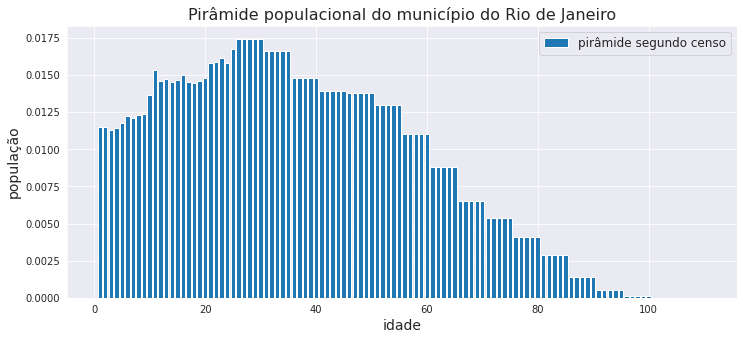

In [8]:
plt.figure(figsize=(12,5))
#plt.hist(pop_idades, bins = list(range(idade_max+1)), color='tab:orange', label='pirâmide obtida')
#plt.step(list(range(1, age_max+1)), age_fractions, label='pirâmide segundo censo')
plt.bar(list(range(1, age_max+1)), age_fractions, label='pirâmide segundo censo')
plt.xlabel('idade', fontsize=14)
plt.ylabel('população', fontsize=14)
plt.title(f'Pirâmide populacional do município do Rio de Janeiro', fontsize=16)
plt.legend(fontsize=12)
plt.show()

## Geração das idades pelas residências
Para a geração de idades dos indivíduos, além da pirâmide etária levaremos em conta também a distribuição das idades nas residências, desta forma definimos um limiar de idade ao qual consideraremos 'adulto', por exemplo `19 anos`, definimos uma sigmoide centrada nesta idade, de forma a termos alguns individuos menores de `19 anos`considerados, assim como indivíduos um pouco maiores dessa idade considerados como não adultos.

In [9]:
age_groups_interp = np.array(list(range(1, age_max+1)))
age_range = [(np.tanh(i * (age_groups_interp - 19)) + 1) / 2 for i in [2/3, -2/3]]

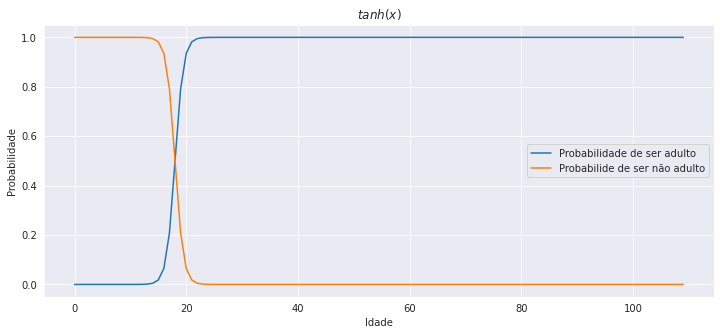

In [10]:
plt.figure(figsize=(12,5))
plt.plot(age_range[0], label = 'Probabilidade de ser adulto')
plt.plot(age_range[1], label = 'Probabilide de ser não adulto')
plt.legend()
plt.xlabel('Idade')
plt.ylabel('Probabilidade')
plt.title('$tanh(x)$')
plt.show()

## Algoritmo para gerar as idades
Com isso podemos seguir o seguinte algoritmo na geração das idades

- São geradas as residências do cenário, assim como os individuos nas residências

- Para todas as residências sorteamos para um dos moradores uma idade **adulta**, seguindo a pirâmide etária e a sigmoide

- Para residências com **2** moradores, sorteamos com probabilidade **90%** e **10%** uma idade adulta ou não adulta para o segundo morador, seguindo a pirâmide etária e a sigmóide

- Para residências com mais de **2** moradores, sorteamos baseado na pirâmide etária a idade dos outros moradores

In [11]:
rio = episiming.scenes.RiodeJaneiro(1/1)

In [12]:
%%time
res = (len(rio.res_sizes_dens) +1)*[[]]
for j in range(1,len(rio.res_sizes_dens)+1):
    # seleciona residências com j indivíduos (res[0]=[])
    res[j] = [r for r in rio.res_pop if len(r) == j]

CPU times: user 1.21 s, sys: 90 µs, total: 1.21 s
Wall time: 1.21 s


In [13]:
res[2][:10]

[[24, 25],
 [52, 53],
 [72, 73],
 [76, 77],
 [86, 87],
 [91, 92],
 [101, 102],
 [111, 112],
 [122, 123],
 [137, 138]]

In [14]:
%%time
res = (len(rio.res_sizes_dens) +1)*[[]]
for j in range(1,len(rio.res_sizes_dens)+1):
    # seleciona residências com j indivíduos (res[0]=[])
    res[j] = [r for r in rio.res_pop if len(r) == j]

CPU times: user 1.32 s, sys: 0 ns, total: 1.32 s
Wall time: 1.32 s


In [15]:
rio.res_size[:10]

[8, 3, 3, 3, 7, 2, 1, 4, 5, 8]

In [16]:
rio.res_pop[:10]

[[0, 1, 2, 3, 4, 5, 6, 7],
 [8, 9, 10],
 [11, 12, 13],
 [14, 15, 16],
 [17, 18, 19, 20, 21, 22, 23],
 [24, 25],
 [26],
 [27, 28, 29, 30],
 [31, 32, 33, 34, 35],
 [36, 37, 38, 39, 40, 41, 42, 43]]

In [17]:
def weighted(l):
    '''
    Make a distribution out of a list or array.
    
    Given any data array or list, this function returns its distribution, or weights which sum to 1
    
    Input:
    ------
        l: list of float/int
            List or Array of data to be made into a distribution
    
    Output:
    -------
        weighted: array of float/int
            The same data as weighted array
    '''
    return np.array(l)/sum(np.array(l))

In [18]:
def sample_from(weights, x):
    '''
    Draw a random sample from desired distribution using the uniform distribution,
    this function mimics np.random.choice, but it's faster if we need to call it a lot of times
    when it's not possible to vectorize.
    
    Input:
    ------
        weights: array of float
            The weights of the distribution
            
        x: float
            Sample previously drawn from uniform distribution, using np.random.rand()
    
    Output:
    -------
        weighted: int
            Index of drawn sample from weights
    '''
    return (weights.cumsum() > x).argmax()

In [19]:
def gen_pop_age(res, res_size, weights, age_groups, n_pop, adult_age = 19, two_res_prob = 0.9):
    """
    Generates the age for the entire population, following a distribution

    Each residence is guaranteed to have at least one adult individual.
    For residences with two individuals, there's a slight chance that the second individual is not an adult
    The age which separates an adult from a non-adult is given by a parameter, and a sigmoid function is built upon this age.
    
    Input:
    ------
        
        res_pop: list
            Nested list of residences with it's individuals
            
        res_size: list
            List with sizes of residences

        weights: array of floats
            Age distribution/weights for the location, this array needs to sum to 1

        age_groups: Array of int
            Group of ages that the model will gather individuals
        
        n_pop: int
            Total number of the population
        
        adult_age: float
            The age which the model should separate an adult from a non-adult
        
        two_res_prob: float
            Probability of a second individual on a two size residence is an adult

    Output:
    -------
        ages: Array of int
            An array with the size of the population,
            each entry representing the age of the individual corresponding to the index on the array
    """
    n_ages = len(weights)
    ages = -1 * np.ones(n_pop, int)
    max_people = np.ceil(n_pop * weights / sum(weights))
    aux = np.random.rand(n_pop)
    age_range = [(np.tanh(i * (age_groups - adult_age)) + 1) / 2 for i in [2/3, -2/3]]
    rng_ages = range(n_ages)
    
    ages_res_adults = np.random.choice(rng_ages, p = weighted(max_people*age_range[0]), size = len(res))
    ages_res_two = np.random.choice(rng_ages, p = weighted(max_people * (age_range[1] if np.random.rand() > two_res_prob else age_range[0])), size = np.count_nonzero(res_size == 2))
    k_adults = 0
    k_two_size = 0
    for i in res:
        if len(i) > 0:
            ages[i[0]] = ages_res_adults[k_adults]
            max_people[ages[i[0]]] -= 1
            k_adults += 1
            if len(i) == 2:
                ages[i[1]] = ages_res_two[k_two_size]
                max_people[ages[i[1]]] -= 1
                k_two_size +=1
     
    ages_res = np.random.choice(range(n_ages), p = weighted(max_people), size = np.count_nonzero(ages == -1))
    j = 0    
    for i in res:
        if len(i) > 2:
            ages[i[1:]] = ages_res[j:(j+len(i) -1)]
            max_people[ages[i[1:]]] -= 1
            j += len(i) -1
    return ages



In [20]:
%%time
ages = gen_pop_age(rio.res_pop, np.array(rio.res_size), np.array(age_fractions), age_groups_interp, len(rio.pop_res))

CPU times: user 9.41 s, sys: 56 ms, total: 9.47 s
Wall time: 9.5 s


## Comparando a pirâmide etária com a geração de idades

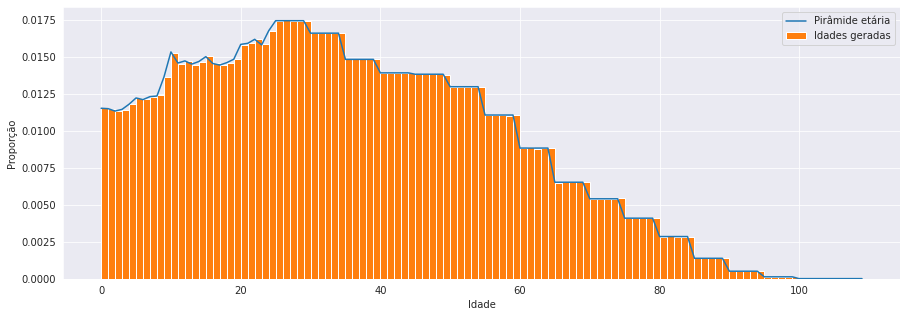

In [21]:
plt.figure(figsize=(15,5))
plt.plot(age_fractions, label = 'Pirâmide etária')
ax = plt.hist(ages, density = True, bins = 109, label = 'Idades geradas')
plt.ylabel('Proporção')
plt.xlabel('Idade')
plt.legend()
plt.show()

Verificando a distribuição de não adultos pelo tamanho das residências

In [22]:
menores = np.arange(len(ages))[ages<=19]

In [23]:
tam_menores = [len(rio.res_pop[rio.pop_res[m]]) for m in menores]

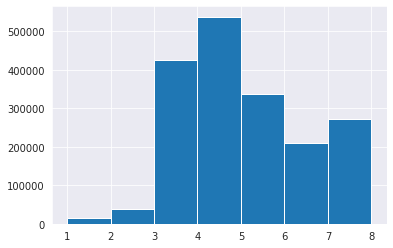

In [24]:
plt.hist(tam_menores, bins = 7)
plt.show()

## Referências

- [DeGroot MH, Schervish MJ (2012), Probability and Statistics, 4th edition, Pearson Education, Inc.](https://www.pearson.com/us/higher-education/program/De-Groot-Probability-and-Statistics-4th-Edition/PGM146802.html).

<!--NAVIGATOR-->

---
[<- Construção dos atributos de localização](01.03-Atributos_de_localizacao.ipynb) | [Página Inicial](00.00-Pagina_Inicial.ipynb) | [Construção dos atributos de idade e infectividade potencial relativa dos indivíduos ->](01.05-Atributos_de_susceptibilidade_e_infectividade.ipynb)